In [15]:
import matplotlib.pyplot as plt

In [16]:
class point:
    def __init__(self,coordx,coordy):
        self.x = coordx
        self.y = coordy

class group:
    points_group = []
    def __init__(self):
        self.points_group = []
    
    def add_point(self,point):
        self.points_group.append(point)

In [17]:
# lendo arquivo de entrada e criando lista de pontos
# abrindo arquivo para leitura
file = open("banana.dat","r")
lines = file.readlines()
# filtrando linhas retirando tudo ate a linha @data
lines = lines[lines.index("@data\n")+1:]

# separando as linhas para 70% treino e 30% teste
treinamento = lines[:int(len(lines)*0.7)]
teste = lines[int(len(lines)*0.7):]

# criando grupos
group1 = group()
group2 = group()

# preenchendo grupos com pontos, sendo que grupo1 sao os pontos da classe 1.0 e grupo2 sao os pontos da classe -1.0
for line in treinamento:
    line = line.split(',')
    if float(line[2]) == 1.0:
        group1.add_point(point(float(line[0]),float(line[1])))
    else:
        group2.add_point(point(float(line[0]),float(line[1])))

# ordenando os pontos de cada grupo em ordem do menor y para o maior y
# para criterio de desempate, ordena-se pelo menor x
group1.points_group.sort(key=lambda point: (point.y,point.x))
group2.points_group.sort(key=lambda point: (point.y,point.x))

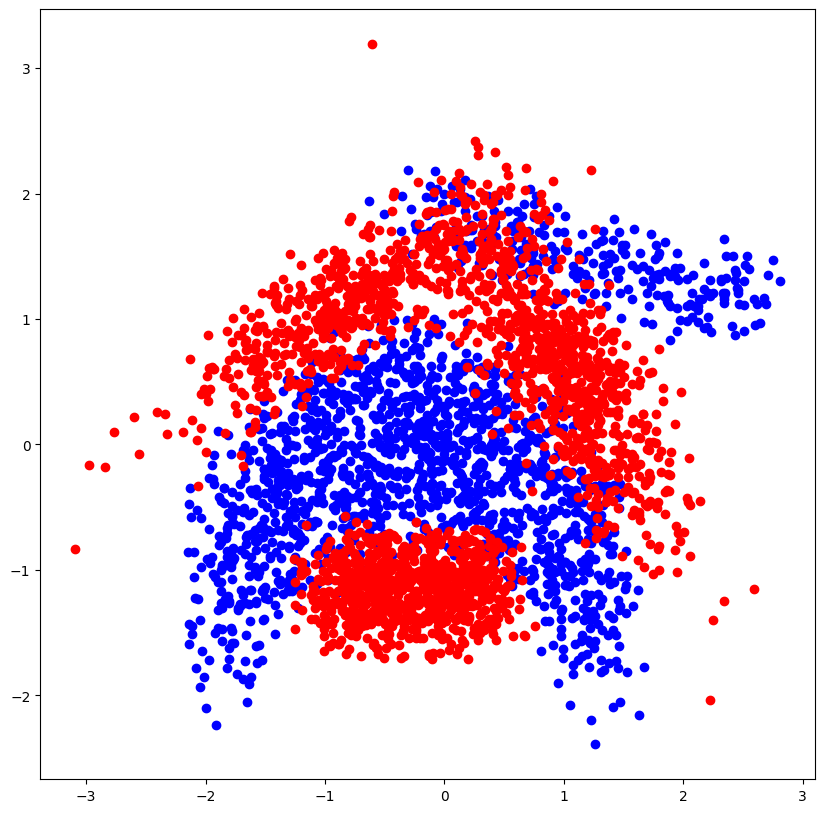

In [18]:
# plotando pontos
# criando figura
fig = plt.figure(figsize=(10,10))
# criando subplot
ax = fig.add_subplot(111)
# plotando pontos do grupo 1
for point in group1.points_group:
    ax.scatter(point.x,point.y,color='b')
# plotando pontos do grupo 2
for point in group2.points_group:
    ax.scatter(point.x,point.y,color='r')
# mostrando figura
plt.show()